# Lab 6: Neural Networks using PyTorch

This lab will implement the neural network structures that were introduced in the lecture. It will review some of the background to neural networks and convolutional operations while testing it out some benchmark datasets. 

**Objectives of this lab**
1. Review the theory of neural networks and convolutions.
2. Implement gradient descent training routines for neural network models.
3. Use PyTorch features for managing data and optimising parameters.
4. Test the performance of neural network models on benchmark datasets.
5. Analyse the architecture of the models to understand what the weights represent.

## 1. Review of Autograd: Automatic Differentiation

In the previous lab, we briefly covered **Tensor** and **Computational Graph**. We have actually used **Autograd** already. Here, we learn the basics below, a condensed and modified version of the original [PyTorch tutorial on Autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py)

#### Why differentiation is important? 

This is because it is a key procedure in **optimisation** to find the optimial solution of a loss function. The process of learning/training aims to minimise a predefined loss.

#### How automatic differentiation is done in PyTorch?
The PyTorch ``autograd`` package makes differentiation (almost) transparent to you by providing automatic differentiation for all operations on Tensors, unless you do not want it (to save time and space). 

A ``torch.Tensor`` type variable has an attribute ``.requires_grad``. Setting this attribute ``True`` tracks (but not computes yet) all operations on it. After we define the forward pass, and hence the *computational graph*, we call ``.backward()`` and all the gradients will be computed automatically and accumulated into the ``.grad`` attribute. 

This is made possible by the [**chain rule of differentiation**](https://en.wikipedia.org/wiki/Chain_rule).

#### How to stop automatic differentiation (e.g., because it is not needed)
Calling method ``.detach()`` of a tensor will detach it from the computation history. We can also wrap the code block in ``with torch.no_grad():`` so all tensors in the block do not track the gradients, e.g., in the test/evaluation stage. 

---
### Question 1

What is the benefit of stopping automatic differentiation when it is not needed?

**Answer**: 

---

In [ ]:
# Reduce computation overhead , Memory usage

#### Function

``Tensor``s are connected by ``Function``s to build an acyclic *computational graph* to encode a complete history of computation. The ``.grad_fn`` attribute of a tensor references a ``Function`` created
the ``Tensor``, i.e., this ``Tensor`` is the output of its ``.grad_fn`` in the computational graph.

Learn more about autograd by referring to the [documentation on autograd](https://pytorch.org/docs/stable/autograd.html)

## 2. Artificial Neurons and Full Connected Neural Networks

As we discussed in the lecture, a simple model of a biological neuron is one where it takes a weighted sum of all it's inputs before transforming it via a non-linear activation function. Historically, this activation function was a step function or more commonly the logistic sigmoid function. In this way, the logistic regression model we saw last week is effectively a single neuron. Mathematically it is defined as
$$ y_i = f \left( b_i + \sum_{j=1}^M W_{ij} x_j \right) $$
where $y_i$ is the value of neuron $i$, $f()$ is the non-linear activation function (e.g sigmoid), $W_{ij}$ is the weight connecting input $x_j$ to neuron $y_i$ and $b_i$ is the bias value for neuron $i$ (this could also be written as $W_{i0}$ but here we use $b$ to align with the PyTorch implementation which separates it out).
This can be written in a vector form as
$$ \mathbf{y} = f \left( \mathbf{b} + W \mathbf{x} \right) $$
This is the case where we have a single input vector, libraries like PyTorch typically process a batch (or mini-batch) of inputs at the same time. In this case if $\mathbf{x}$ is a 2d array shaped (Batch size, Input size) then this operation can be written as
$$ \mathbf{y} = f \left( \mathbf{b} + \mathbf{x} W^T \right) $$
where now $\mathbf{y}$ is also a 2d array but with a shape (Batch size, Number of neurons). We have to transpose $W$ so that the shapes of the arrays are correct while mathematically to operation is the same. Note that we also need to broadcast the bias vector to each sample output in the batch.

In PyTorch the weighted sum is known as a fully connected **linear** layer (see the documentation [here](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)). PyTorch has a submodule of the library called ``torch.nn`` that contains implementations of various common neural network operations that make building neural network models easy. You started using these in Lab 6 but let's look at chaining them together to create neural networks.

A single layer of neurons are similar to what we have seen for linear and logistic regression. While these work for some situations, they are only linear models so when it comes to predicting classes or outputs which have complex non-linear relations of the inputs then we need to expand our models. We have already discussed using basis functions and design matrices to modify our input to include a non-linear basis. In artificial neural networks, we rely on connecting layers of neurons to discover these complex feature representations for us. So if we have a non-linear task that we want to solve we can instead create a stack of neuron layers, this is a specific form of neural networks known as a **feedforward neural network** (FFNN). In a FFNN the neurons only propagate information in one direction with no communication within layers. A 2 layer FFNN can be described as:
$$ 
\mathbf{h} = f_{(1)} \left( \mathbf{x} W^T_{(1)} \right) \\
\mathbf{y} = f_{(2)} \left( \mathbf{h} W^T_{(2)} \right)
$$ 
where $\mathbf{h}$ are the values of the neurons in the intermediate layer, usually known as a hidden layer. $\mathbf{y}$ is the values of the neurons in the final layer, which are usually known as the output neurons. When we are training the network we will usually be guiding these outputs towards a particular target. In this case we have 2 activation functions and 2 weight matrices which are describing the connection between the input and hidden layer, and then between the hidden layer and output layer.

Let's look at implementing this using PyTorch. We will use a simple example where we have an input size of 3, 4 neurons in the hidden layer and 1 output neuron.

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt


# Input vector 
x = torch.Tensor([1.0, 2.0, 3.0])

# Using torch.nn we can create objects that will perform the neural network operations
# For the fully connected layer we must specify the size of the input and how many hidden neurons we want.
# PyTorch will randomly initialise the weights for us.
fc1 = nn.Linear(in_features=3, out_features=4, bias=True )
f_act1 = nn.Sigmoid()

# Now we can apply both operations to the input to give the values of the hidden layer.
h = f_act1( fc1(x))
print("h is ", h)

# We can find the values of the weights and bias from the Linear class object
print("The fc1 weights are ", fc1.weight)
print("The fc1 biases area ", fc1.bias)

# Now we can define the second (output) layer
fc2 = nn.Linear(in_features=4, out_features=1, bias=True)
f_act2 = nn.Sigmoid()

# Applying the second layer to the hidden layer
y = f_act2( fc2(h))

# So the output of our neural network is
print("y is ", y.item())


h is  tensor([0.4010, 0.3244, 0.2787, 0.4794], grad_fn=<SigmoidBackward0>)
The fc1 weights are  Parameter containing:
tensor([[-0.1176, -0.5334,  0.3704],
        [ 0.1283,  0.0293, -0.2780],
        [-0.2695,  0.2980, -0.4862],
        [-0.1848, -0.1079, -0.0319]], requires_grad=True)
The fc1 biases area  Parameter containing:
tensor([-0.3282, -0.0869,  0.1812,  0.4137], requires_grad=True)
y is  0.6170722246170044


For neural networks PyTorch also provides a wrapper to contain all these layers in a single object, known as a `nn.Sequential`. So instead of creating the 4 objects above, we can create a single model as follows:

In [2]:
model = nn.Sequential(
    nn.Linear(in_features=3, out_features=4, bias=True ), 
    nn.Sigmoid(),
    nn.Linear(in_features=4, out_features=1, bias=True),
    nn.Sigmoid()
)

# We can get some information about the model by printing it
print(model)

# And we can apply it but simply providing the input. The Sequential class will automatically feed to output of one layer into the next
y = model(x)

print("y is ", y.item())

Sequential(
  (0): Linear(in_features=3, out_features=4, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=4, out_features=1, bias=True)
  (3): Sigmoid()
)
y is  0.46701768040657043


In [3]:

# Layers in the Sequential model can also be accessed via an index, so model[i] will return layer i
print('Model layer 1 is: ', model[1])

# We can then directly access the weights and biases from the linear layers if we want
print('The weights for the first linear layer are: ', model[0].weight)

# The sequential model also automatically registers the relevant parameters of each layer
# and provides an iterator to access all the parameters of the model. This used when we
# want to tell a PyTorch optimiser which parameters to update.  
for p in model.parameters():
    print(p)

Model layer 1 is:  Sigmoid()
The weights for the first linear layer are:  Parameter containing:
tensor([[-0.0180, -0.3750, -0.5567],
        [ 0.1986,  0.0207, -0.4778],
        [ 0.3231, -0.4420,  0.4854],
        [ 0.5683, -0.0726,  0.4135]], requires_grad=True)
Parameter containing:
tensor([[-0.0180, -0.3750, -0.5567],
        [ 0.1986,  0.0207, -0.4778],
        [ 0.3231, -0.4420,  0.4854],
        [ 0.5683, -0.0726,  0.4135]], requires_grad=True)
Parameter containing:
tensor([ 0.4206, -0.0778,  0.1716, -0.5020], requires_grad=True)
Parameter containing:
tensor([[ 0.4963,  0.3205, -0.3458,  0.2727]], requires_grad=True)
Parameter containing:
tensor([0.2233], requires_grad=True)


## 3. Image Classification Using Neural Networks

We will now look at the application of these neural network models to an image classification task. We will use the digits dataset from Scikit-Learn based around small images of handwritten digits. Scikit-learn provides a function to download and import the necessary data into a numpy array. We will also use the Scikit-Learn train_test_split function to separate the data into a training and testing component. 

When we load the data it may not be normalised. **You should write in a minmax normalisation step into the following code.**



In [4]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import numpy as np

# load_digits() will return a bunch object containing the data and targets as well as some information about the targets.
digits = load_digits()

print(f'The digits.data values are in the range {digits.data.min()} to {digits.data.max()}.')

# Apply the Minmax normalisation here
norm_data = digits.data

print(f'The norm data values are in the range {norm_data.min()} to {norm_data.max()}.')

#train_test_split will randomly split the data into the specified sizes. 
# Here we will specify the size of the training set (so that we have a convenient size)
x_train, x_test, y_train, y_test = train_test_split( norm_data, digits.target, train_size=1400)

print(len(x_train), len(x_test))


The digits.data values are in the range 0.0 to 16.0.
The norm data values are in the range 0.0 to 16.0.
1400 397


When using the fully connected `nn.Linear` layers it is expecting the input to be in the form of a single array **per sample**. When we are processing images we will need to flatten them from a 2d or 3d image shape to 1d. The `digits.data` array has already flattened the images for us, the original image is 8 by 8 pixels which is reshaped into a 64 length array.

There is 1400 training samples, each of length 64.
Here is an image with a 9.


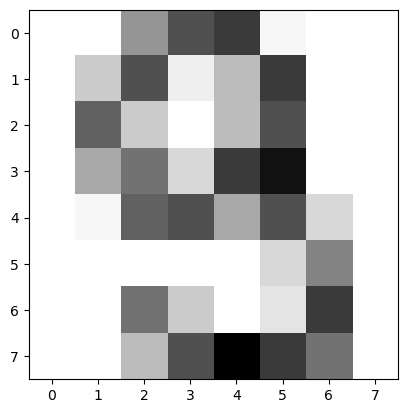

In [5]:
print(f'There is {x_train.shape[0]} training samples, each of length {x_train.shape[1]}.')

id = 3
print(f'Here is an image with a {y_train[id]}.')
plt.imshow(x_train[id].reshape((8,8)), cmap='Greys')
plt.show()

We can now test using the `nn.Sequential` neural network to make predictions on these images. First we will need to convert the numpy arrays into PyTorch Tensors. Later on the loss function will expect the true output to be in the format of the class label with a long datatype. The y_train array already contains the class labels (as opposed to a one hot encoding) and so we just need to use the `.long()` internal tensor function to convert it.

In [6]:
x_train_t = torch.Tensor(x_train)
y_train_t = torch.Tensor(y_train).long()

x_test_t = torch.Tensor(x_test)
y_test_t = torch.Tensor(y_test).long()

Now we can create a model that has the correct number of inputs and outputs. Remember, when we are training these classifiers we generally use a `one-hot` encoded target. You can interpret this as the posterior probabilities (i.e the probability that input $x$ belongs to to class $i$) so each element of the output array will be related to $P(\mathrm{class}=i | \mathbf{x})$ and to make a classification we will need to find the predicted output that has the largest value. In this example we will look at using the Cross Entropy Loss (CEL) function for training our model. It is defined as 
$$ L = - \sum_{n=1}^N \sum_{i=1}^{C} t_{ni} \log(p_{ni}) $$
where $t_{ni}$ is the one-hot encoded target of sample $n$ and $p_{ni}$ is the predicted output probability of class $i$ of sample $n$. $N$ is the total number of samples and $C$ the number of classes (i.e. outputs). Compared to the mean-squared error, where we use the squared magnitude of the difference between the predictions and targets, this is measuring the difference in the probability distributions of our target and predictions. It is specifically expecting the prediction to be in terms of a probability and one of the best ways to convert a multi-class output into a probability is to use the **softmax** operation.This converts an array into a normalised probability by applying the following operation
$$ p_{ni} = \frac{\exp(y_{ni})}{\sum_j \exp({y_{nj}})} ,$$
where $n$ is for a sample and $i$ indicates the output index of the network. The division here computes the total 'probability' and normalises it. By using softmax and Cross-Entropy Loss we change the output range that our neural network is being trained to learn. For mean squared error we would want our outputs to be usually in the range 0 to 1, or -1 to 1, but now we can see from the softmax operation to maximise the probability of one class over the others we will want the outputs to be +$\infty$ for the correct output and $-\infty$ for the others. This wider range can help during the training.

In PyTorch, the cross entropy loss function will automatically apply the softmax to a network output so when we create the network we leave the final layer as a linear layer rather than applying an activation function. We still need an activation function for the hidden layer.

Now we will move to defining a simple neural network model with one hidden layer.

In [7]:
# The input size for our neural network is the number of features in our data
feature_size = x_train_t.shape[-1]

# The output size will have to match the number of classes we are aiming to predict
output_size = len(np.unique(digits.target))

# The size of the hidden layer is now defined by us. Usually the bigger the hidden
# layer the better the model performs.
hidden_size = 10

# Using the torch Sequential model we will now create a neural network model with
# one hidden layer. We will specify that the biases are used as well.
digits_model = nn.Sequential(
    nn.Linear(in_features=feature_size, out_features=hidden_size, bias=True),
    nn.Sigmoid(),
    nn.Linear(in_features=hidden_size, out_features=output_size, bias=True)
)

# The sequential model allows us to access each layer through an index.
# Here I will extract the weight matrix from the first linear layer for 
# a comparison later. Detach removes it from gradient calculation and 
# clone will create a copy.
untrained_weights = digits_model[0].weight.detach().clone()

The model is untrained at the moment but we input our data to see what it predicts initially. Note that in this case we can pass the **entire** training matrix at once to the model. The PyTorch Linear layers are expecting the input data to be in the shape of `(number_of_samples, input_features)` and it will return a tensor that will be `(number_of_samples, output_features)`. The Linear layer will only operate on the final dimension of the data and so can actually work on inputs that have more dimensions. By passing the entire dataset it will process all the predictions at once.

Remember, the output of the model is how strong the model considers that input to belonging to that class. Since we haven't directly applied the softmax in the model it is not a probability but it is related. The common choice is to predict the class that is the index of the largest output. We can do this with `argmax`. 

In [8]:
# Testing the model on the training data
predictions = digits_model(x_train_t)

print( 'The network outputs are ', predictions[0])
print( f'The predicted class will be {torch.argmax(predictions[0]).item()}')
print( f'The true class is {y_train_t[0]}')

The network outputs are  tensor([-0.5097,  0.0673,  0.0378, -0.5047,  0.4462,  0.6027, -0.4048, -0.2472,
        -0.5770,  0.2867], grad_fn=<SelectBackward0>)
The predicted class will be 5
The true class is 5


We can see our prediction is far from correct, but this is to be expected as it is an untrained model at this stage. 

Since the output of the model is an array of the predictions for all the samples, we can pass this array to the `argmax` and specify to do this operation only on a specific axis. For example `argmax(x, axis=1)` will find the indices of the maximums but only in axis 1. For our data, this means we can use it to get the per sample argmax to predict our class labels.

### Question 2

Using the predictions, implement a function to calculate the accuracy (i.e number of correctly predicted labels out of the whole training set). How good is your model? Is it what you expected?

In [9]:
def accuracy(predictions, labels):
    return 1.0

print(accuracy(predictions, y_train_t))

1.0


### Question 3

We have a working model, so we now need to train it using gradient descent. Complete the training routine below to make predictions based on the training data, compute the loss and then update the weights using an optimiser. You can look at the routines in Lab 5 as a reference.

Store the loss and accuracy at every epoch (iteration) and then plot these at the end. Has the training converged in the specified number of iterations?

**Beware** since your model was defined in previous cell, everytime that you re-run the training cell it will continue from the current version of the model. This is good if you want to refine the training but not if you want to start from the beginning. If you want to start from the initial model you will need to define it at the beginning of the training.


In [ ]:
from torch import optim

Max_Niter = 50
step_size = 0.01

# I have provided the loss function and an optimiser to use
loss_func = torch.nn.CrossEntropyLoss()

# We need to register the parameters with the optimiser
opt = optim.SGD(digits_model.parameters(), lr = step_size)

loss_data = torch.zeros(Max_Niter)
acc_data = torch.zeros(Max_Niter)

# Epoch (iteration) loop to repeatedly process the data then update the weights
for i in range(Max_Niter):

    # Before starting the predictions we should zero the gradients. 
    # Are you sure why this is the case?
    opt.zero_grad()

    # Now the main 'forward' phase of the model
    #predictions = 
    #loss = 

    # A section to print out the progress and for the 'backward' phase with applying the optimiser
    # Uncomment and complete the training
    # REMEMBER use torch.no_grad to avoid calculating gradients
    with torch.no_grad():
        #acc_data[i] =
        #loss_data[i] = 
        if (i % 10 == 0): print( f'epoch: {i:5d}, loss: {loss_data[i].item():.3f}, accuracy: {acc_data[i].item():.3f}')

        #Compute the gradients and step the optimiser


epoch:     0, loss: 0.000, accuracy: 0.000
epoch:    10, loss: 0.000, accuracy: 0.000
epoch:    20, loss: 0.000, accuracy: 0.000
epoch:    30, loss: 0.000, accuracy: 0.000
epoch:    40, loss: 0.000, accuracy: 0.000


In [11]:
# Plot the training loss and accuracy over the epoch (iterations)

### Question 4

When you are happy with the performance of the model on the training data, calculate the loss and accuracy on the test data. This was stored in the `x_test_t` and `y_test_t` tensors defined above. How do these values compare to the values on the training data?

In [12]:
# test_accuracy =

### Analysing the weights

Now that the weights should be trained, they will start to learn combined features within in the inputs. This is easier to visualise in the first layer as it is directly connected to the input data. The code below will plot your trained weights compared to the untrained ones. They initially start off as random but we should be able to make out some features. Whilst they are stored as a row in the weight matrix we can visualise them as a 2d image by reshaping them. What features can you make out?

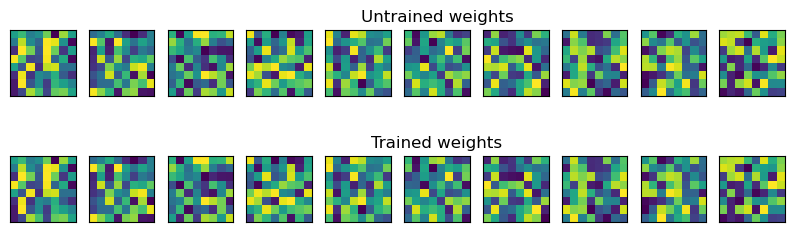

In [13]:
fig, axs = plt.subplots(nrows=2, ncols=hidden_size,  sharex=True, sharey=True, )
fig.set_size_inches(10, 3)

axs[0,hidden_size//2].set_title(f'Untrained weights')
for j in range(hidden_size):
    axs[0,j].set_yticks([])
    axs[0,j].set_xticks([])
    axs[0,j].imshow(untrained_weights[j].reshape((8,8)))
plt.plot()

axs[1,hidden_size//2].set_title('Trained weights')
for j in range(hidden_size):
    axs[1,j].set_yticks([])
    axs[1,j].set_xticks([]) 
    axs[1,j].imshow(digits_model[0].weight.detach()[j].reshape((8,8)))

plt.show()

### Question 5

Try experimenting with the neural network model that we defined above and applying the training routine to it. For example you can increase the size of the hidden layer or even add in another hidden layer. This is a fairly simple data set so you will find that you do not need a very large model. You could also try some different activation functions or other layers such as [Batch Normalisation](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d).

How does the accuracy on the test set compare to the model with only 1 hidden layer before? What conclusions can you draw about this classification task? Can it be solved by a simple model?

When you have trained it, try to plot the weights of the first layer as I have done in the cell above. Have the features changed? Try making it a one layer model, again how does it compare to these models.

In [14]:
digits_model2 = nn.Sequential(
    #implement your model here
)

# Apply your training routine. You might find it useful to define the training as a function that you can call repeatedly.

### Section summary

This has shown how to implement a multi-layer neural network using the PyTorch library. We have used the `nn.Sequential` class to bring together multiple layers which are applied one after the other to a given input. Through training the network we can classify the test data relatively well and this can be improved using bigger hidden layers or more layers. 

You can find some more information about using PyTorch [here](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html) and [here](https://pytorch.org/tutorials/beginner/nn_tutorial.html).

## 4. Convolutional Neural Networks 


**Suggested reading**: 
* [Convolutional neural network - Wikipedia](https://en.wikipedia.org/wiki/Convolutional_neural_network)
* [Feature/representation learning - Wikipedia](https://en.wikipedia.org/wiki/Feature_learning)

### Introduction

The fast rising of [deep learning](https://en.wikipedia.org/wiki/Deep_learning) starts on 30 September 2012, when a convolutional neural network (CNN) called [AlexNet](https://en.wikipedia.org/wiki/AlexNet) achieved a top-5 error of 15.3% in the ImageNet 2012 Challenge, more than **10.8 percentage** points lower than that of the runner up. This is considered a breakthrough and has grabbed the attention of increasing number of researchers, practioners, and the general public. Since then, deep learning has penetrated to many research and application areas. AlexNet contained **eight layers**. A sketch of it is given below to show how it combines convolution layers with fully connected (dense) ones to perform classification.

![Alexnet](https://upload.wikimedia.org/wikipedia/commons/a/a9/AlexNet_Original_block_diagram.svg)

In 2015, it was outperformed by a very deep CNN with **over 100 layers** from Microsoft in the ImageNet 2015 contest. It will be interesting to take a look at the image classification task and a CNN that can do the job well.



### Architecture of a Convolutional Neural Network (CNN)

A typical CNN architecture can be seen here. Each layer has a set of convolution filters, also known as kernels. Each filter is shared across the outputs of the layer, a more intuitive way is to consider that the filter is 'scanning' across the image and the resulting output is what we call a feature map. Essentially this means a map of where each of the features the filters are finding are present in the input image. This means that the output of the convolution is also image-like data. The layers process in turn to build up lower level features into complex high level features.

![Typical CNN architecture](https://upload.wikimedia.org/wikipedia/commons/6/63/Typical_cnn.png)

Let us look at the convolution operation in detail.

### Convolution layer - with a shared kernel/filter

THe convolution operation is still performing a weighted sum but in a more structure manner.

<center>
<img src="https://www.cs.toronto.edu/~lczhang/360/lec/w04/imgs/math_kernel.png" width="100px" style="margin:0; display:inline">
<img src="https://www.cs.toronto.edu/~lczhang/360/lec/w04/imgs/math_conv.png" width="300px" style="margin:0; display:inline">
</center>

The light blue grid (middle) is the *input* that we are given, e.g., a 5 pixel by 5 pixel greyscale image. The grey grid (left) is a **convolutional kernel/filter** of size $3 \times 3$, containing the *parameters* of this neural network layer.

To compute the output, we superimpose the kernel on a region of the image. 
Let's start at the top left, in the dark blue region. The small numbers in the
bottom right corner of each grid element corresponds to the number in the kernel.
To compute the output at the corresponding location (top left), we "dot" the
pixel intensities in the square region with the kernel. That is, we perform
the computation:

In [15]:
(3 * 0 + 3 * 1 + 2 * 2) + (0 * 2 + 0 * 2 + 1 * 0) + (3 * 0 + 1 * 1 + 2 * 2)

12

The green grid (right) contains the *output* of this convolution layer.
This output is also called an **output feature map**. The terms **feature**,
and **activation** are interchangable. The output value on the top left
of the green grid is consistent with the value we obtained by hand in Python.

To compute the next activation value (say, one to the right of the previous output),
we will shfit the superimposed kernel over by one pixel:

<img src="https://www.cs.toronto.edu/~lczhang/360/lec/w04/imgs/math_conv2.png" width="300px">

The dark blue region is moved to the right by one pixel. We again dot
the pixel intensities in this region with the kernel to get another 12, and continues to get 17, ...

### Question 6

Show how we get the value 19 in cell (1,2) of the output above (middle right cell).

**Answer**: 

---

**Note the shrinking output**: Here, we did not use **zero padding** (at the edges) so the output of this layers is reduced by 1 on all sides. If the kernel size is $k=2m+1$, the output will be reduced by $m$ on all sides so the width and height will be both reduced by $2m$.

#### Convolutions with Multiple Input/Output Channels

For a colour image, the kernel will be a **3-dimensional tensor**. This kernel will move through the input features just like before, and we "dot" the pixel intensities with the kernel at each region, exactly like before. This "size of the 3rd (colour) dimension" is called the **number of input channels** or **number of input feature maps**.

We also want to detect multiple features, e.g., both horizontal edges and vertical edges. We would want to learn **many** convolutional filters on the same input. That is,
we would want to make the same computation above using different kernels, like this:

<img src="https://upload.wikimedia.org/wikipedia/commons/6/68/Conv_layer.png" width="200px">

Each circle on the right of the image represents the output of a different kernel dotted
with the highlighted region on the right. So, the output feature is also a 3-dimensional tensor.
The size of the new dimension
is called the **number of output channels** or **number of output feature maps**.
In the picture above, there are 5 output channels.

The `conv2D` layer expects as input a tensor in the format "NCHW", meaning that the dimensions of the tensor should follow the order:

* batch size
* channel
* height
* width

Let us create a convolutional layer using `nn.Conv2d`:

In [16]:
myconv1 = nn.Conv2d(in_channels=3,  # number of input channels
                 out_channels=7, # number of output channels
                 kernel_size=5)  # size of the kernel, 

In [17]:
#Emulate a batch of 32 colour images, each of size 128x128, like this:
x = torch.randn(32, 3, 128, 128)
y = myconv1(x)
y.shape

torch.Size([32, 7, 124, 124])

The output tensor is also in the "NCHW" format. We still have 32 images, and 7 channels
(consistent with `out_channels` of `conv`), and of size 124x124. If we added the appropriate
padding to `conv`, namely `padding` = $m$ (the kernel_size: $2m+1$), then our output width and height should be consistent with the input width and height:

In [18]:
myconv2 = nn.Conv2d(in_channels=3,
                  out_channels=7,
                  kernel_size=5,
                  padding=2)

x = torch.randn(32, 3, 128, 128)
y = myconv2(x)
y.shape

torch.Size([32, 7, 128, 128])

#### The parameters of `Conv2d`

In [19]:
conv_params = list(myconv2.parameters())
print("len(conv_params):", len(conv_params))
print("Filters:", conv_params[0].shape)  #7 filters, each of size 3 x 5 x 5
print("Biases:", conv_params[1].shape)

len(conv_params): 2
Filters: torch.Size([7, 3, 5, 5])
Biases: torch.Size([7])


### Pooling Layers - Subsampling

A pooling layer can be created like this: 
<img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/Max_pooling.png" width="300px">

In [20]:
mypool = nn.MaxPool2d(kernel_size=2, stride=2)
y = myconv2(x)
z = mypool(y)
z.shape

torch.Size([32, 7, 64, 64])

Usually, the kernel size and the stride length will be equal so each pixel is pooled only once. 
The pooling layer has **no trainable parameters**:

In [21]:
list(mypool.parameters())

[]

In Lab 5, we did not define a class for our linear regression NN. Here we do so and define a CNN class consisting of several layers as defined below.

In [22]:
myCNN = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6,  kernel_size=3),     
            nn.ReLU(),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.Flatten(),  # This will flatten our 16,4,4 internal representation into a vector
            nn.Linear(in_features= 16 * 4 * 4, out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=10)
)

`ReLu()` is the [rectified linear unit](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)), a popular **activation function** that performs a *nonlinear* transformation/mapping of an input variable (element-wise operation). `Conv2d()` defines a convolution layer, as shown below where blue maps indicate inputs, and cyan maps indicate outputs.

<table>
    <tr>
    <td  style="text-align: left"> Convolution with no padding, no strides.      <img src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif" alt="Drawing" style="width: 250px;"/> </td>
</tr>
</table>

More convolution layers are illustrated nicely at [Convolution arithmetic](https://github.com/vdumoulin/conv_arithmetic). 


This network `myCNN` defined above has **two** convolutional layers: `conv1` and `conv2`.

- The first convolutional layer `conv1` requires an input with 3 channels,
  outputs **6 channels**, and has a kernel size of `3x3`. We are not adding any zero-padding.
- The second convolutional layer `conv2` requires an input with **6 channels** (note this **MUST match the output channel number of the previous layer**),  outputs 16 channels, and has a kernel size of (again) `3x3`. We are not adding any zero-padding.

In the model, we see that the convolution operations are always followed by the usual ReLU activation function.
Because we are not adding any zero padding, we end up with `16 * 4 * 4` hidden units
after the second convolutional layer (`16` matches the output channel number of `conv2`, `4 * 4` is based on the input dimension being reduced as described below). These units are then passed to two fully-connected layers, with the usual ReLU activation in between.

Notice that the number of channels **grew** in later convolutional layers! However, without padding
the number of hidden units in each layer will be reduced because of the convolution operation.
We can calculate the size of the output dimensions using
$$ O = \frac{N - F + 2P}{S} + 1 $$
where $N$ is the height or width of the input, F is the filter/kernel size, P is the padding and S is the stride.
We are not using padding or strides yet so the image will be slightly reduced. Typically we will want to reduce the feature map
size whilst increasing 

* Initial Image Size: $1 \times 8 \times 8 $
* After `conv1`: $6 \times 6 \times 6$ (reduction of 1 per side) 
* After `conv2`: $16 \times 4 \times 4$ (reduction of 1 per side) 
* After `fc1`: $64$
* After `fc2`: $10$ (**= number of classes**)

### Question 7

If the input image size is $3 \times 64 \times 64 $, can we use the same CNN defined above? 

If yes, show the feature sizes after each operation as above. If no, how shall we modify the network architecture to process such $3 \times 64 \times 64 $ images?

**Answer**: 

---

#### Inspect the NN architecture

Now let's take a look at the CNN model. 

In [23]:
print(myCNN)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=256, out_features=50, bias=True)
  (6): ReLU()
  (7): Linear(in_features=50, out_features=10, bias=True)
)


Let us check the (randomly initialised) parameters of this NN. Below, we check the first 2D convolution. 

In [24]:
params = list(myCNN.parameters())
print(len(params))
print(params[0].size())  # First Conv2d's .weight
print(params[1].size())  # First Conv2d's .bias
print(params[1])

8
torch.Size([6, 1, 3, 3])
torch.Size([6])
Parameter containing:
tensor([-0.0600, -0.1785,  0.0090, -0.1645,  0.2135, -0.3111],
       requires_grad=True)


### Question 8

From the above, we can see the length of `params` is 8, i.e. there are 8 sets of parameters. Set 0 is for the weights of `conv1`. Set 1 is the bias of `conv1`. What are the remaining 6 sets for?

**Answer**: 

---

To learn more about these functions, refer to the [`torch.nn` documentation](https://pytorch.org/docs/stable/nn.html) (search for the function, e.g., search for `torch.nn.ReLu` and you will find its documentation [here](https://pytorch.org/docs/stable/nn.html?highlight=relu#torch.nn.ReLU).

### Optimisation, Training and Testing

Hopefully you now have a clearer picture of what the convolution layers are doing. We have defined a model so now we can apply it to the digits data as before.
In our earlier training we used all the training data before updating the weights. Splitting the training set into batches can allow for faster updates and quicker convergence. To do this we will use some more features from PyTorch - `Datasets` and `DataLoaders`. The datasets are useful wrappers for the tensors but the DataLoader is important for providing batches for the training loop.

`torch.utils.data.DataLoader` combines a dataset and a sampler, and provides an iterable over the given dataset. See [API here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)

**Batching**

We want to use more than one images at one time. That way, we can compute the *average* loss across a **mini-batch** of $n$ *multiple* images, and take a step to optimize the *average* loss. The average loss across multiple training inputs is going to be **less "noisy"** than the loss for a single input, and is less likely to provide "bad information" because of a "bad" input. The number $n$ is called the **batch size**.

The actual batch size that we choose depends on many things. We want our batch
size to be large enough to not be too "noisy", but not so large as to make each
iteration too expensive to run.

People often choose batch sizes of the form $n=2^k$ so that it is easy to half or double the batch size. 

**Epoch**

The way `DataLoader` works is that it randomly groups the training data into **mini-batches**
with the appropriate batch size. Each data point belongs to only one mini-batch. When there
are no more mini-batches left, the loop terminates.

In general, we may wish to train the network for longer. We may wish to use each training data
point more than once. In other words, we may wish to train a neural network for more than
**one epoch**. An **epoch** is a measure of the number of times all training data is used
once to update the parameters. 

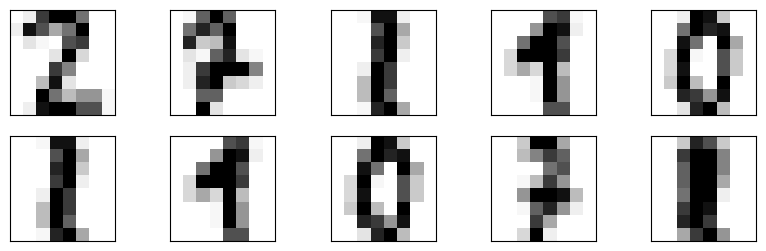

In [25]:
from torch.utils.data import TensorDataset, DataLoader

# Convert our 'flattened' images back to 2d but also including the colour channel
x_train_t = x_train_t.reshape((-1, 1, 8, 8))
x_test_t  = x_test_t.reshape((-1, 1, 8, 8))

# From the base tensors we can combine the input and targets into a TensorDataset
digits_train_set = TensorDataset(x_train_t, y_train_t)

# The DataLoader will select a batch of samples from the dataset to present to the model
# Shuffle=True will give a different grouping of samples each time.
digits_train_dl = DataLoader(digits_train_set, batch_size=10, shuffle=True)

# We will wrap the test set as well but since we are not training using it we can
# return the whole dataset at once. 
digits_test_set = TensorDataset(x_train_t, y_train_t)
digits_test_dl = DataLoader(digits_train_set, batch_size=len(digits_test_set), shuffle=True)


# Plot a single batch, the DataLoader is iterable, so we can use iter() and next() to
# extract data from it.
images, labels = next(iter(digits_train_dl))
fig, axs = plt.subplots(2, 5, sharex=True, sharey=True)
fig.set_size_inches(10, 3)
for i in range(2):
    for j in range(5):
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].imshow(images[i*2 + j, 0], cmap='Greys')

plt.show()

#### Training the network

Training the CNN model happens in the same way as for the fully connected model before but now we have an inner loop that iterates over the batches. We want to make predictions, calculate the loss and optimise at each iteration of the batch (dataloader) but we only want to take statistics over the full training data. Below is a skeleton code to do this, using your version from the fully connected network before, update the following code to train the `myCNN` model.

In [33]:
Max_Niter = 50
step_size = 0.01

loss_func = torch.nn.CrossEntropyLoss()
opt = optim.SGD(myCNN.parameters(), lr = step_size)

loss_data = torch.zeros(Max_Niter)
acc_data = torch.zeros(Max_Niter)

# Epoch (iteration) loop to repeatedly process the data then update the weights
for i in range(Max_Niter):
    
    for j, (images, labels) in enumerate(digits_train_dl):
        opt.zero_grad()

        # 'forward' phase of the model
        #predictions = ...
        #loss = ...

        # Now that we are doing batches we need to accumulate the loss and accuracy
        #acc_data[i] +=
        #loss_data[i] += loss.item()

        # 'backward' phase: compute gradients then step optimiser

    with torch.no_grad():
        if (i % 10 == 0): 
            print( f'epoch: {i:5d}, loss: {loss_data[i].item():.3f}, accuracy: {acc_data[i].item():.3f}')

print('Finished Training!')

epoch:     0, loss: 0.000, accuracy: 0.000
epoch:    10, loss: 0.000, accuracy: 0.000
epoch:    20, loss: 0.000, accuracy: 0.000
epoch:    30, loss: 0.000, accuracy: 0.000
epoch:    40, loss: 0.000, accuracy: 0.000
Finished Training!


Take a look at how `autograd` keeps track of the gradients for back propagation.

In [34]:
print(loss.grad_fn)
print(loss.grad_fn.next_functions[0][0])

#### Saving our trained model

When we have a model that is fully optimised we will want to store it for future use. We can do this using the `torch.save` function below

In [35]:
PATH = 'digits_CNN.pth'
torch.save(myCNN.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html)
for more details on saving PyTorch models.

#### Loading a saved model

If we have a saved model we will probably want to load it again for further testing. The code below will do that for us.

In [36]:
# First we need a structure that we can load the model parameters into.
# We do have the myCNN() defined above but we can create a new Sequential model
# then load the parameters into that. The model has to match the size.
loadCNN = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6,  kernel_size=3),     
            nn.ReLU(),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.Flatten(),  # This will flatten our 16,4,4 internal representation into a vector
            nn.Linear(in_features= 16 * 4 * 4, out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=10)
)

loadCNN.load_state_dict(torch.load(PATH))

<All keys matched successfully>

#### Test performance
Let us look at how the network performs on the test set. Uncomment and fill in the code to compute the accuracy using the testloader below. We might have used a batchsize for the test loader so we might need to accumulate the test accuracy over batches. I sepecifed it to have only 1 batch so it should work without.

In [30]:
test_acc = 0.0
#for images, labels in digits_test_dl:
    #predictions = ...
    #test_acc = ...
print(f'Test accuracy = {test_acc}')

Test accuracy = 0.0


### Question 9

What is the **chance level** accuracy (i.e. if the model randomly picked one of the 10 classes independent of the input)? How good is your CNN accuracy compared to the chance level?

**Answer**: 

---

If your network works better than chance, it seems like to have learnt something.

It can be useful to analyse whether the model achieves better performance on certain classes than others. Adapt your test accuracy code from above so that it calculates the accuracy for each class separately.

In [31]:
class_correct = np.zeros(10)
class_total = np.zeros(10)

with torch.no_grad():
    for images, labels in digits_test_dl:
        

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

IndentationError: expected an indented block after 'for' statement on line 5 (1047834529.py, line 8)

You might find the model does better on some classes than others. Try adjusting your model to see if you can improve performance. Try to plot out the convolutional filters from this model similar to how we plotted the weights for the linear network before. The filters are already 2d so they won't need reshaping!

## 5. Applying a CNN to a more complex dataset

To finish, we will explore using the a CNN model on a dataset that is harder to classify than the digits. The [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) has ten classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

**Loading and normalizing CIFAR10**

The output of torchvision datasets (after loading) are PILImage images of range [0, 1]. 

Check out the `torchvision.transforms` API for [here](https://pytorch.org/docs/stable/torchvision/transforms.html) (search for `ToTensor` and `Normalize`).

`transforms.ToTensor()` Convert a `PIL` Image or `numpy.ndarray` (H x W x C) in the range [0, 255]  to torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].

`transforms.Normalize` normalizes a tensor image with mean and standard deviation. Given mean: ($M_1,...,M_n$) and std: ($S_1,..,S_n$) for $n$ channels, this transform will normalize each channel of the input `torch.*Tensor` as `input[channel] = (input[channel] - mean[channel]) / std[channel]`

`torch.utils.data.DataLoader` combines a dataset and a sampler, and provides an iterable over the given dataset. See [API here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)

In [39]:
import torchvision
from torchvision import datasets, transforms

batchSize=8
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#Load the training data
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,shuffle=True)

#Load the test data
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print('Training set size:', len(trainset))
print('Test set size:',len(testset))

Files already downloaded and verified
Files already downloaded and verified
Training set size: 50000
Test set size: 10000


### Plotting the data

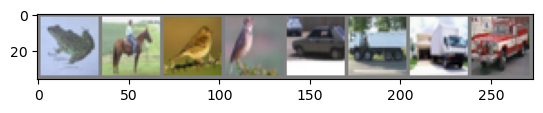

 frog horse  bird  bird   car truck truck truck


In [40]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize back to range [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #rearrange dimensions to numpy format for disply
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter) #Get one batch (8 here)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batchSize)))

Now, to show you a new way to create models, instead of using Sequential we can create our classes that inherit from PyTorch's modules class. The code below will create a feed forward CNN that is very similar to that we made before but larger and with some pooling layers.



In [42]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d( in_channels=3, out_channels=6, kernel_size=5) 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.act = nn.ReLU(),
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(self.act(self.conv1(x)))
        x = self.pool(self.act(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

cifar_CNN = CNN()

`__init__()` defines the layers.  `forward()` defines the *forward pass* that transform the input to the output.
In the `forward` function we see that the convolution operations are always 
followed by the usual ReLU activation function, and a pooling operation.
The pooling operation used is max pooling, so each pooling operation
**reduces the width and height of the neurons in the layer by half**.



Because we are not adding any zero padding, we end up with `16 * 5 * 5` hidden units
after the second convolutional layer (`16` matches the output channel number of `conv2`, `5 * 5` is based on the input dimension `32x32`, see below). These units are then passed to two fully-connected
layers, with the usual ReLU activation in between.

Notice that the number of channels **grew** in later convolutional layers! However,
the number of hidden units in each layer is still reduced because of the convolution and pooling operation:

* Initial Image Size: $3 \times 32 \times 32 $
* After `conv1`: $6 \times 28 \times 28$ ($32 \times 32$ is reduced by `2` on each side)
* After Pooling: $6 \times 14 \times 14 $ (image size halved)
* After `conv2`: $16 \times 10 \times 10$ ($14 \times 14$ is reduced by `2` on each side)
* After Pooling: $16 \times 5 \times 5 $ (halved)
* After `fc1`: $120$
* After `fc2`: $84$
* After `fc3`: $10$ (**= number of classes**)

This pattern of **doubling the number of channels with every pooling / strided convolution**
is common in modern convolutional architectures. It is used to avoid loss of too much information within
a single reduction in resolution.

### Question 10

Adapt your code from before to use the cifar dataloaders to train the `cifar_CNN` model. Use the corresponding test set to calculate the accuracy of the model. You might find that your accuracy only reaches around 50% but see how well you can improve this. 


## Additional ideas to explore

* Change the [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions) to different choices and compare the results.
* Train the network for more passes (epochs) and/or other training settings (e.g., other patch sizes) to study performance variations.
* Practice change the CNN architecture (pay attention to the size matching between different layers).
* Try on GPU if you have one by following the end of the [the CIFAR10 Pytorch tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py).
* Try out the AlexNet `torchvision.models.alexnet` and other architectures from `torchvision.models` for image classification
* Try out other pytorch computer vision datasets `torchvision.datasets` for image classification. 